In [155]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [156]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import ResNet50

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder


### Extract ResNet50 Features and Train Logistic Regression

In [40]:
image_ids = np.load("./Data/SAM_Dataset/image_ids.npy")

image_id_classes = [image_id.split("/")[0] for image_id in image_ids]

encoder = LabelEncoder()

y = encoder.fit_transform(image_id_classes)

In [41]:
feature_extractor = ResNet50(weights='imagenet', include_top=False, pooling='avg')

In [7]:
X_0 = np.load("./SAM/dataset_severity_0.npy")
X_0_features = feature_extractor.predict(X_0)

2025-04-11 19:30:12.737325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


207/207 ━━━━━━━━━━━━━━━━━━━━ 32s 144ms/step


In [8]:
X_1 = np.load("./SAM/dataset_severity_1.npy")
X_1_features = feature_extractor.predict(X_1)

207/207 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step


In [9]:
X_2 = np.load("./SAM/dataset_severity_2.npy")
X_2_features = feature_extractor.predict(X_2)

207/207 ━━━━━━━━━━━━━━━━━━━━ 29s 136ms/step


In [43]:
def split_matrix(X, y, test_size=0.2, use_val=True):
    X_train, X_temp, y_train, y_temp = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=42,
        shuffle=True,
        stratify=y
    )

    if not use_val:
        return X_train, X_temp, y_train, y_temp
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp,
        y_temp,
        test_size=0.5,  
        random_state=42,
        shuffle=True,
        stratify=y_temp  
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

In [83]:
from imblearn.over_sampling import SMOTE

def log_train(
        features, 
        y, 
        use_smote=True, 
        max_iter=1000, 
        test_size=0.2, 
        use_val=True
    ):
    
    X_train, X_val, X_test, y_train, y_val, y_test = split_matrix(features, y, test_size=test_size, use_val=use_val)

    if use_smote:
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)


    log_reg = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
    log_reg.fit(X_train, y_train)

    # Predict on test data
    y_pred = log_reg.predict(X_test)

    y_prob = log_reg.predict_proba(X_test)

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")  

    return y_pred, y_prob, y_test

In [157]:
y_pred, y_prob, y_test = log_train(X_1_features, y, use_smote=False)

### Evaluate Results

In [136]:
report = classification_report(y_test, y_pred, target_names=encoder.classes_, output_dict=True)

classes = []
precisions = []
recalls = []
f1_scores = []
for key in report.keys():
    if key in  encoder.classes_:
        classes.append(key)
        precisions.append(report[key]['precision'])
        recalls.append(report[key]['recall'])
        f1_scores.append(report[key]['f1-score'])


# Create pandas dataframe of classification metrics from lists
import pandas as pd
classification_metrics = pd.DataFrame({
    'Class': classes,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})

In [137]:
coverage_df = np.load("./Data/SAM_dataset/coverage_df.npy", allow_pickle=True)
coverage_df = pd.DataFrame(coverage_df, columns=['Class', 'Coverage'])
coverage_df = coverage_df.groupby("Class")["Coverage"].mean().sort_values(ascending=False)
# Merge classification metrics with coverage
classification_metrics = pd.merge(classification_metrics, coverage_df, on='Class', how='left')
classification_metrics = classification_metrics.sort_values(by='F1 Score', ascending=False)
classification_metrics['Coverage'] = classification_metrics['Coverage'].astype(float)
classification_metrics

,Class,Precision,Recall,F1 Score,Coverage
1,fogsmog,0.987654,1.000000,0.993789,0.762215
5,lightning,1.000000,0.972222,0.985915,0.901753
7,rainbow,1.000000,0.956522,0.977778,0.907304
9,sandstorm,0.984375,0.954545,0.969231,0.857352
6,rain,0.921569,0.940000,0.930693,0.794567
0,dew,0.926471,0.913043,0.919708,0.787131
4,hail,0.910714,0.910714,0.910714,0.789137
8,rime,0.869565,0.877193,0.873362,0.734043
10,snow,0.771930,0.758621,0.765217,0.735959
3,glaze,0.731343,0.777778,0.753846,0.661986


In [134]:
classification_metrics['Original Precision'] = orig_resnet_precisions
classification_metrics['Original Recall'] = orig_resnet_recalls

classification_metrics['Precision Change'] = (
    classification_metrics['Precision'] - classification_metrics['Original Precision']
)

classification_metrics['Recall Change'] = (
    classification_metrics['Recall'] - classification_metrics['Original Recall']
)

classification_metrics.set_index('Class', inplace=True)

classification_metrics

,Precision,Recall,F1 Score,Coverage,Original Precision,Original Recall,Precision Change,Recall Change
Class,,,,,,,,
fogsmog,0.987654,1.000000,0.993789,0.762215,0.94,0.93,0.047654,0.070000
lightning,1.000000,0.972222,0.985915,0.901753,0.94,0.94,0.060000,0.032222
rainbow,1.000000,0.956522,0.977778,0.907304,0.82,0.75,0.180000,0.206522
sandstorm,0.984375,0.954545,0.969231,0.857352,0.79,0.87,0.194375,0.084545
rain,0.921569,0.940000,0.930693,0.794567,0.96,0.94,-0.038431,0.000000
dew,0.926471,0.913043,0.919708,0.787131,0.97,0.96,-0.043529,-0.046957
hail,0.910714,0.910714,0.910714,0.789137,0.92,0.91,-0.009286,0.000714
rime,0.869565,0.877193,0.873362,0.734043,0.98,1.00,-0.110435,-0.122807
snow,0.771930,0.758621,0.765217,0.735959,0.91,0.88,-0.138070,-0.121379


In [138]:
# Numbers from separate run of ResNet50 on the original dataset by another team member, from visual of classification report

orig_resnet_precisions = np.load("./Data/SAM_dataset/orig_resnet_precisions.npy", allow_pickle=True)
orig_resnet_recalls = np.load("./Data/SAM_dataset/orig_resnet_recalls.npy", allow_pickle=True)
class_order = sorted(encoder.classes_)

orig_resnet_precisions_dict = {class_: precision for class_, precision in zip(class_order, orig_resnet_precisions)}
orig_resnet_recalls_dict = {class_: recall for class_, recall in zip(class_order, orig_resnet_recalls)}
classification_metrics['Original Precision'] = classification_metrics['Class'].map(orig_resnet_precisions_dict)
classification_metrics['Original Recall'] = classification_metrics['Class'].map(orig_resnet_recalls_dict)
classification_metrics['Precision Change'] = classification_metrics['Precision'] - classification_metrics['Original Precision']
classification_metrics['Recall Change'] = classification_metrics['Recall'] - classification_metrics['Original Recall']

In [139]:
classification_metrics

,Class,Precision,Recall,F1 Score,Coverage,Original Precision,Original Recall,Precision Change,Recall Change
1,fogsmog,0.987654,1.000000,0.993789,0.762215,0.94,0.94,0.047654,0.060000
5,lightning,1.000000,0.972222,0.985915,0.901753,0.97,0.96,0.030000,0.012222
7,rainbow,1.000000,0.956522,0.977778,0.907304,0.98,1.00,0.020000,-0.043478
9,sandstorm,0.984375,0.954545,0.969231,0.857352,0.94,0.97,0.044375,-0.015455
6,rain,0.921569,0.940000,0.930693,0.794567,0.92,0.91,0.001569,0.030000
0,dew,0.926471,0.913043,0.919708,0.787131,0.94,0.93,-0.013529,-0.016957
4,hail,0.910714,0.910714,0.910714,0.789137,0.96,0.94,-0.049286,-0.029286
8,rime,0.869565,0.877193,0.873362,0.734043,0.91,0.88,-0.040435,-0.002807
10,snow,0.771930,0.758621,0.765217,0.735959,0.84,0.88,-0.068070,-0.121379
3,glaze,0.731343,0.777778,0.753846,0.661986,0.79,0.87,-0.058657,-0.092222


([0, 1, 2, 3, 4],
 [Text(0, 0, 'Original ResNet'),
  Text(1, 0, 'Low Removal'),
  Text(2, 0, 'Moderate Removal'),
  Text(3, 0, 'High Removal'),
  Text(4, 0, 'Moderate Removal w/SMOTE')])

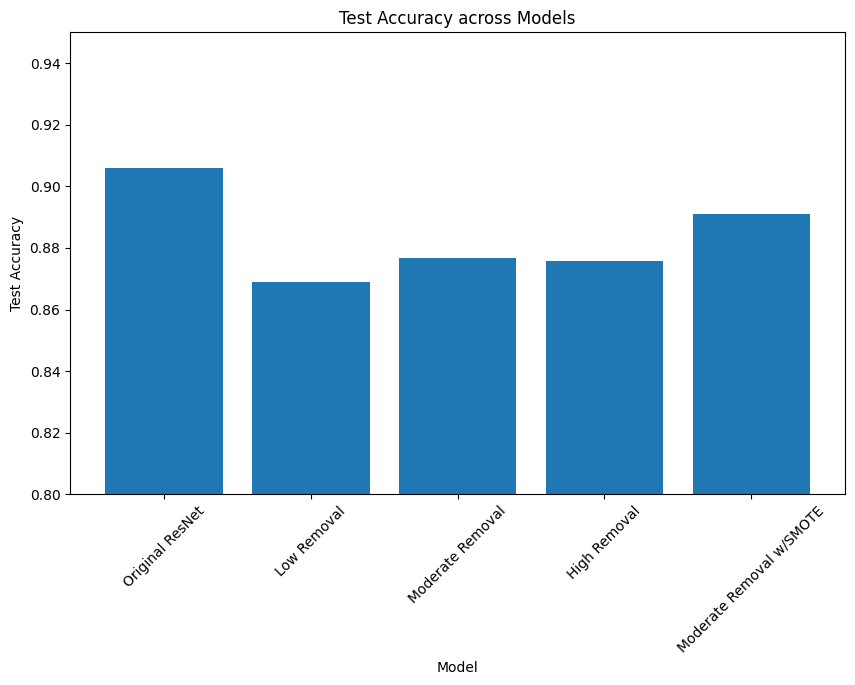

In [153]:
models = ["Original ResNet", "Low Removal", "Moderate Removal", "High Removal", "Moderate Removal w/SMOTE"]
# Numbers from Separate Runs of above script
test_accuracies = np.load("./Data/SAM_dataset/test_accuracies.npy", allow_pickle=True)

results = pd.DataFrame(data=[models, test_accuracies]).T
results.columns = ['Model', 'Test Accuracy']
results['Test Accuracy'] = results['Test Accuracy'].astype(float)

# Plot bar graph
plt.figure(figsize=(10, 6))
plt.bar(results['Model'], results['Test Accuracy'])
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy across Models')
plt.ylim(0.8, 0.95)
plt.xticks(rotation=45)

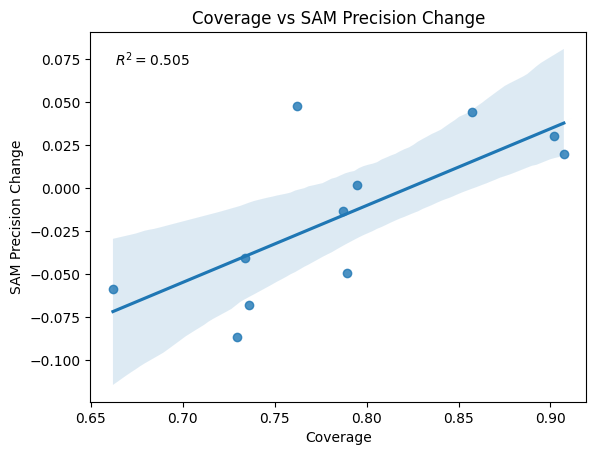

In [144]:
import seaborn as sns

x = classification_metrics['Coverage'].values
y = classification_metrics['Precision Change'].values
m, b = np.polyfit(x, y, 1)
sns.regplot(x=x, y=y)

# optional: compute R² and annotate
from sklearn.metrics import r2_score
r2 = r2_score(y, [m * xi + b for xi in x])
plt.text(
    0.05, 0.95,
    f'$R^2 = {r2:.3f}$',
    transform=plt.gca().transAxes,
    verticalalignment='top'
)

plt.xlabel('Coverage')
plt.ylabel('SAM Precision Change')
plt.title('Coverage vs SAM Precision Change')
plt.show()

In [50]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


X_2_train, X_2_test, y_2_train, y_2_test = split_matrix(X_2_features, y, test_size=0.4, use_val=False)

# Initialize T-SNE with 2 components
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data to 2D
X_2_train_embedded = tsne.fit_transform(X_2_train)

In [73]:
def plot_tsne(X_embedded, y_train, zoom=None):  

    unique_classes= np.unique(y_train)
    plt.figure(figsize=(10, 8))
    for label in unique_classes:
        indices = np.where(y_train == label)
        plt.scatter(X_embedded[indices, 0], X_embedded[indices, 1], label=encoder.inverse_transform([label])[0], alpha=0.5)

    # Plot the results with color mapping from y_train
    
    # Display the number of points in the plot
    plt.title('SAM + Resnet50 t-SNE Projection of X_train (n = {}, n_classes = {})'.format(X_embedded.shape[0], len(unique_classes)))  
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

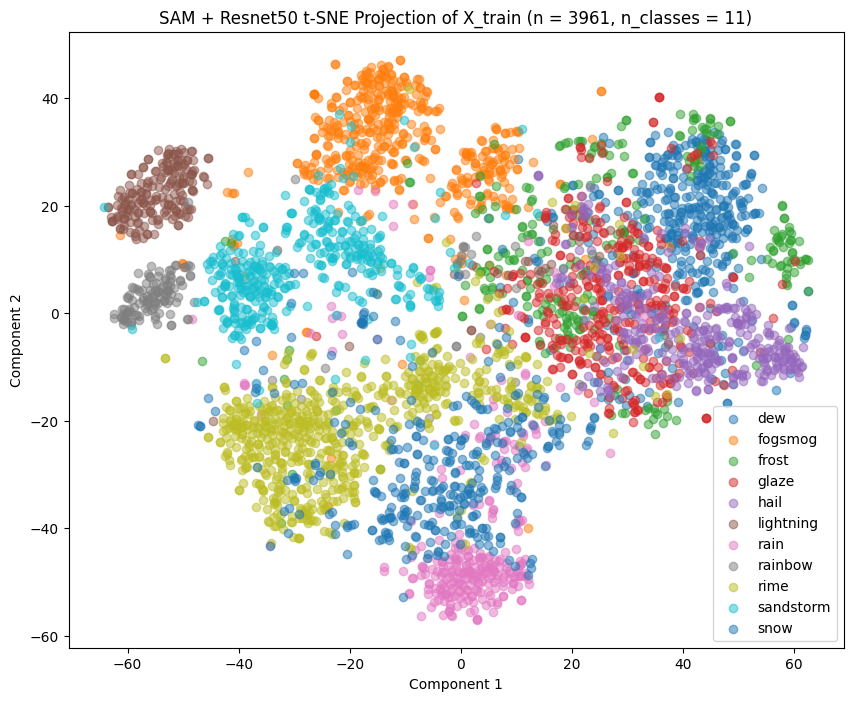

In [74]:
plot_tsne(X_2_train_embedded, y_2_train, zoom=None)